In [9]:
import os, sys, time, glob, random, argparse
import numpy as np
from copy import deepcopy
import torch
import torch.nn as nn
import time
import tqdm
import scipy.stats as stats
import matplotlib.pyplot as plt
import pickle

# XAutoDL 
from xautodl.config_utils import load_config, dict2config, configure2str
from xautodl.datasets import get_datasets, get_nas_search_loaders
from xautodl.procedures import (
    prepare_seed,
    prepare_logger,
    save_checkpoint,
    copy_checkpoint,
    get_optim_scheduler,
)
from xautodl.utils import get_model_infos, obtain_accuracy
from xautodl.log_utils import AverageMeter, time_string, convert_secs2time
from xautodl.models import get_search_spaces

# API
from nats_bench import create

# custom modules
from custom.tss_model import get_cell_based_tiny_net
from ZeroShotProxy import *

In [2]:
parser = argparse.ArgumentParser("Training-free NAS on NATSBench (TSS)")
parser.add_argument("--data_path", type=str, default='./cifar.python', help="The path to dataset")
parser.add_argument("--dataset", type=str, default='cifar10',choices=["cifar10", "cifar100", "ImageNet16-120"], help="Choose between Cifar10/100 and ImageNet-16.")

# channels and number-of-cells
parser.add_argument("--search_space", type=str, default='tss', help="The search space name.")
parser.add_argument("--config_path", type=str, default='./configs/nas-benchmark/algos/weight-sharing.config', help="The path to the configuration.")
parser.add_argument("--max_nodes", type=int, default=4, help="The maximum number of nodes.")
parser.add_argument("--channel", type=int, default=16, help="The number of channels.")
parser.add_argument("--num_cells", type=int, default=5, help="The number of cells in one stage.")
# parser.add_argument("--channel", type=int, default=3, help="The number of channels.")
# parser.add_argument("--num_cells", type=int, default=1, help="The number of cells in one stage.")
# parser.add_argument("--select_num", type=int, default=100, help="The number of selected architectures to evaluate.")
parser.add_argument("--affine", type=int, default=0, choices=[0, 1], help="Whether use affine=True or False in the BN layer.")
parser.add_argument("--track_running_stats", type=int, default=0, choices=[0, 1], help="Whether use track_running_stats or not in the BN layer.")

# log
parser.add_argument("--print_freq", type=int, default=200, help="print frequency (default: 200)")

# custom
parser.add_argument("--gpu", type=int, default=0, help="")
parser.add_argument("--workers", type=int, default=2, help="number of data loading workers")
parser.add_argument("--api_data_path", type=str, default="./api_data/NATS-tss-v1_0-3ffb9-simple/", help="")
parser.add_argument("--save_dir", type=str, default='./results/tmp', help="Folder to save checkpoints and log.")
parser.add_argument('--zero_shot_score', type=str, default='ETF', help='could be: ETF; ZiCo (form ZiCo); params, (for \#Params); Zen (for Zen-NAS); TE (for TE-NAS)')
parser.add_argument("--rand_seed", type=int, default=None, help="manual seed")
args = parser.parse_args(args=[])

if args.rand_seed is None or args.rand_seed < 0:
    args.rand_seed = random.randint(1, 100000)

print(args.rand_seed)
print(args)
xargs=args

51974
Namespace(data_path='./cifar.python', dataset='cifar10', search_space='tss', config_path='./configs/nas-benchmark/algos/weight-sharing.config', max_nodes=4, channel=16, num_cells=5, affine=0, track_running_stats=0, print_freq=200, gpu=0, workers=2, api_data_path='./api_data/NATS-tss-v1_0-3ffb9-simple/', save_dir='./results/tmp', zero_shot_score='ETF62', rand_seed=51974)


In [3]:
assert torch.cuda.is_available(), "CUDA is not available."
torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = False
torch.backends.cudnn.deterministic = True
torch.set_num_threads(xargs.workers)
prepare_seed(xargs.rand_seed)
logger = prepare_logger(args)

Main Function with logger : Logger(dir=results/tmp, use-tf=False, writer=None)
Arguments : -------------------------------
data_path        : ./cifar.python
dataset          : cifar10
search_space     : tss
config_path      : ./configs/nas-benchmark/algos/weight-sharing.config
max_nodes        : 4
channel          : 16
num_cells        : 5
affine           : 0
track_running_stats : 0
print_freq       : 200
gpu              : 0
workers          : 2
api_data_path    : ./api_data/NATS-tss-v1_0-3ffb9-simple/
save_dir         : ./results/tmp
zero_shot_score  : ETF62
rand_seed        : 51974
Python  Version  : 3.10.9 (main, Mar  8 2023, 10:47:38) [GCC 11.2.0]
Pillow  Version  : 9.4.0
PyTorch Version  : 2.0.0
cuDNN   Version  : 8500
CUDA available   : True
CUDA GPU numbers : 2
CUDA_VISIBLE_DEVICES : None


In [4]:
## API
api = create(xargs.api_data_path, xargs.search_space, fast_mode=True, verbose=False)
logger.log("Create API = {:} done".format(api))

## data
train_data, valid_data, xshape, class_num = get_datasets(xargs.dataset, xargs.data_path, -1)
config = load_config(xargs.config_path, {"class_num": class_num, "xshape": xshape}, logger)
search_loader, train_loader, valid_loader = get_nas_search_loaders(train_data,
                                                                   valid_data,
                                                                   xargs.dataset,
                                                                   "./configs/nas-benchmark/",
                                                                   (config.batch_size, config.test_batch_size),
                                                                   xargs.workers,)
logger.log("||||||| {:10s} ||||||| Search-Loader-Num={:}, Valid-Loader-Num={:}, batch size={:}".format(xargs.dataset, len(search_loader), len(valid_loader), config.batch_size))
logger.log("||||||| {:10s} ||||||| Config={:}".format(xargs.dataset, config))

## model
search_space = get_search_spaces(xargs.search_space, "nats-bench")
model_config = dict2config(
    dict(
        name="generic",
        C=xargs.channel,
        N=xargs.num_cells,
        max_nodes=xargs.max_nodes,
        num_classes=class_num,
        space=search_space,
        affine=bool(xargs.affine),
        track_running_stats=bool(xargs.track_running_stats),
    ),
    None,
)
logger.log("search space : {:}".format(search_space))
logger.log("model config : {:}".format(model_config))
search_model = get_cell_based_tiny_net(model_config)

device = torch.device('cuda:{}'.format(xargs.gpu))
network = search_model.to(device)

Create API = NATStopology(0/15625 architectures, fast_mode=True, file=) done
Files already downloaded and verified
Files already downloaded and verified
./configs/nas-benchmark/algos/weight-sharing.config
Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=100, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
||||||| cifar10    ||||||| Search-Loader-Num=391, Valid-Loader-Num=49, batch size=64
||||||| cifar10    ||||||| Config=Configure(scheduler='cos', LR=0.025, eta_min=0.001, epochs=100, warmup=0, optim='SGD', decay=0.0005, momentum=0.9, nesterov=True, criterion='Softmax', batch_size=64, test_batch_size=512, class_num=10, xshape=(1, 3, 32, 32))
search space : ['none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x3', 'avg_pool_3x3']
model config : Configure(name='generic', C=16, N=5, max_nodes=4, num_classes=10, space=['none', 'skip_connect', 'nor_conv_1x1', 'nor_conv_3x

In [5]:
def search_find_best(xargs, xloader, network, n_samples = None, archs = None):
    if 'etf' in xargs.zero_shot_score.lower():
        score_fn_name = "compute_{}_score".format(args.zero_shot_score.lower())
        score_fn = globals().get(score_fn_name)
        input_, target_ = next(iter(xloader))
        resolution = input_.size(2)
        batch_size = input_.size(0)
        zero_shot_score_dict = None
        arch_list = []
    else:
        raise NotImplementedError
    
    if archs is None and n_samples is not None:
        network.train()
        all_time = []
        all_mem = []
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for i in tqdm.tqdm(range(n_samples)):
            # random sampling
            arch = network.random_genotype(True)

            start.record()
            torch.cuda.reset_peak_memory_stats()

            info_dict = score_fn.compute_nas_score(model=network, gpu=xargs.gpu, trainloader=None, resolution=resolution, batch_size=batch_size)

            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
            all_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()

            arch_list.append(arch)
            if zero_shot_score_dict is None: # initialize dict
                zero_shot_score_dict = dict()
                for k in info_dict.keys():
                    zero_shot_score_dict[k] = []
            for k, v in info_dict.items():
                zero_shot_score_dict[k].append(v)

        print("------Runtime------")
        print("All: {:.5f} ms".format(np.mean(all_time)))
        print("------Avg Mem------")
        print("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
        print("------Max Mem------")
        print("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    elif archs is not None and n_samples is None:
        network.train()
        all_time = []
        all_mem = []
        start = torch.cuda.Event(enable_timing=True)
        end = torch.cuda.Event(enable_timing=True)
        for arch in tqdm.tqdm(archs):
            network.arch_cache = arch

            start.record()
            torch.cuda.reset_peak_memory_stats()

            info_dict = score_fn.compute_nas_score(model=network, gpu=xargs.gpu, trainloader=None, resolution=resolution, batch_size=batch_size)

            end.record()
            torch.cuda.synchronize()
            all_time.append(start.elapsed_time(end))
            all_mem.append(torch.cuda.max_memory_reserved())
            torch.cuda.empty_cache()

            arch_list.append(arch)
            if zero_shot_score_dict is None: # initialize dict
                zero_shot_score_dict = dict()
                for k in info_dict.keys():
                    zero_shot_score_dict[k] = []
            for k, v in info_dict.items():
                zero_shot_score_dict[k].append(v)

        print("------Runtime------")
        print("All: {:.5f} ms".format(np.mean(all_time)))
        print("------Avg Mem------")
        print("All: {:.5f} GB".format(np.mean(all_mem)/1e9))
        print("------Max Mem------")
        print("All: {:.5f} GB".format(np.max(all_mem)/1e9))
        
    return arch_list, zero_shot_score_dict

In [32]:
######### search across random N archs #########
archs, results = search_find_best(xargs, train_loader, network, n_samples=1000)

# ######### search across N archs uniformly sampled according to test acc. #########
# def uniform_sample_archs(network, xargs, api, n_samples=1000, dataset='cifar10'):
#     arch = network.random_genotype(True)
#     search_space = get_search_spaces(xargs.search_space, "nats-bench")
#     archs = arch.gen_all(search_space, xargs.max_nodes, False)
    
#     def get_results_from_api(api, arch, dataset='cifar10'):
#         dataset_candidates = ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120']
#         assert dataset in dataset_candidates
#         index = api.query_index_by_arch(arch)
#         api._prepare_info(index)
#         archresult = api.arch2infos_dict[index]['200']
#         if dataset == 'cifar10-valid':
#             acc = archresult.get_metrics(dataset, 'x-valid', iepoch=199, is_random=False)['accuracy']
#         else:
#             acc = archresult.get_metrics(dataset, 'ori-test', iepoch=199, is_random=False)['accuracy']
#         return acc

#     accs = []
#     for a in archs:
#         accs.append(get_results_from_api(api, a, dataset))
#     interval = len(archs) // n_samples
#     sorted_indices = np.argsort(accs)
#     new_archs = []
#     for i, idx in enumerate(sorted_indices):
#         if i % interval == 0:
#             new_archs.append(archs[idx])
#     archs = new_archs
    
#     return archs

# if os.path.exists("./tss_uniform_arch.pickle"):
#     with open("./tss_uniform_arch.pickle", "rb") as fp:
#         uniform_archs = pickle.load(fp)
# else:
#     uniform_archs = uniform_sample_archs(network, xargs, api, 1000, 'cifar10')
#     with open("./tss_uniform_arch.pickle", "wb") as fp:
#         pickle.dump(uniform_archs, fp)
# archs, results = search_find_best(xargs, train_loader, network, archs=uniform_archs)


# ######### search across all archs #########
# def generate_all_archs(network, xargs):
#     arch = network.random_genotype(True)
#     search_space = get_search_spaces(xargs.search_space, "nats-bench")
#     archs = arch.gen_all(search_space, xargs.max_nodes, False)
#     return archs

# all_archs = generate_all_archs(network, xargs)
# archs, results = search_find_best(xargs, train_loader, network, archs=all_archs)

100%|██████████| 3000/3000 [02:54<00:00, 17.23it/s]

------Runtime------
All: 51.18043 ms
------Avg Mem------
All: 0.31016 GB
------Max Mem------
All: 0.54945 GB


In [35]:
def get_results_from_api(api, arch, dataset='cifar10'):
    dataset_candidates = ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120']
    assert dataset in dataset_candidates
    index = api.query_index_by_arch(arch)
    api._prepare_info(index)
    archresult = api.arch2infos_dict[index]['200']
    
    if dataset == 'cifar10-valid':
        acc = archresult.get_metrics(dataset, 'x-valid', iepoch=199, is_random=False)['accuracy']
    else:
        acc = archresult.get_metrics(dataset, 'ori-test', iepoch=199, is_random=False)['accuracy']
    flops = archresult.get_compute_costs(dataset)['flops']
    params = archresult.get_compute_costs(dataset)['params']
    
    return acc, flops, params

api_valid_accs, api_flops, api_params = [], [], []
for a in archs:
#     valid_acc, flops, params = get_results_from_api(api, a, 'cifar10')
#     valid_acc, flops, params = get_results_from_api(api, a, 'cifar100')
    valid_acc, flops, params = get_results_from_api(api, a, 'ImageNet16-120')
    api_valid_accs.append(valid_acc)
    api_flops.append(flops)
    api_params.append(params)

|nor_conv_3x3~0|+|nor_conv_3x3~0|none~1|+|nor_conv_1x1~0|nor_conv_3x3~1|nor_conv_3x3~2|
datasets : ['cifar10-valid', 'cifar10', 'cifar100', 'ImageNet16-120'], extra-info : arch-index=3928
cifar10-valid  FLOP=153.27 M, Params=1.073 MB, latency=22.10 ms.
cifar10-valid  train : [loss = 0.002 & top1 = 99.98%], valid : [loss = 0.477 & top1 = 90.41%]
cifar10        FLOP=153.27 M, Params=1.073 MB, latency=22.10 ms.
cifar10        train : [loss = 0.003 & top1 = 99.95%], test  : [loss = 0.304 & top1 = 93.61%]
cifar100       FLOP=153.28 M, Params=1.079 MB, latency=20.22 ms.
cifar100       train : [loss = 0.035 & top1 = 99.68%], valid : [loss = 1.280 & top1 = 71.16%], test : [loss = 1.298 & top1 = 71.16%]
ImageNet16-120 FLOP= 38.33 M, Params=1.081 MB, latency=21.58 ms.
ImageNet16-120 train : [loss = 1.586 & top1 = 57.19%], valid : [loss = 2.160 & top1 = 45.17%], test : [loss = 2.166 & top1 = 45.29%]
aggregated: 0.7019333223931365	0.8798476987475875	0.8798476987475875	


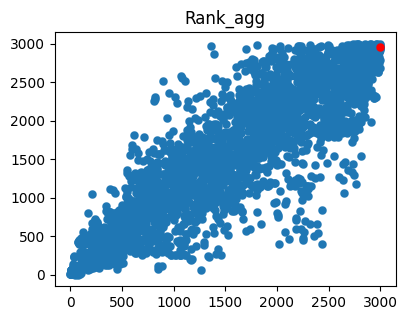

FLOPs: 0.5205957130131099	0.694368197284942	0.694368197284942	


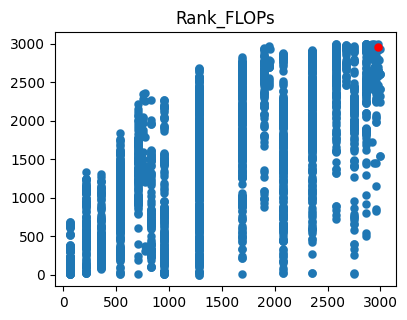

Params: 0.5239656022261046	0.6953431917960586	0.6953431917960586	


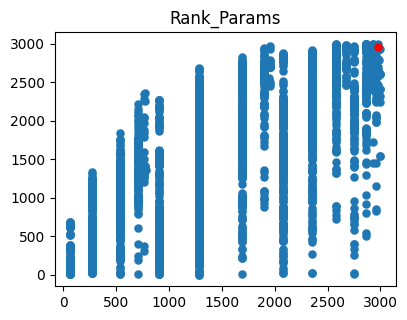

expressivity: 0.5004892211540922	0.6922735522928489	0.6922735522928489	


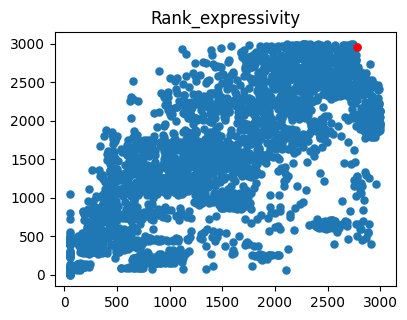

info_flow: 0.47195045192326596	0.6383754292075625	0.6383754292075625	


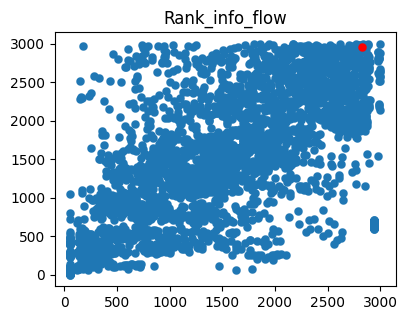

trainability: 0.41387606436213376	0.5814562560641159	0.581456256064116	


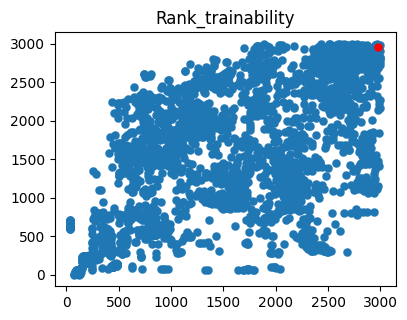

In [36]:
fig_scale = 1.1

l = len(api_flops)
rank_agg = np.log(stats.rankdata(api_flops) / l)
for k in results.keys():
    rank_agg = rank_agg + np.log( stats.rankdata(results[k]) / l)
    
# rank_agg = None
# for k in results.keys():
#     if rank_agg is None:
#         rank_agg = np.log( stats.rankdata(results[k]) / l)
#     else:
#         rank_agg = rank_agg + np.log( stats.rankdata(results[k]) / l)

# rank_agg = np.log( stats.rankdata(results['expressivity']) / l)
    
best_idx = np.argmax(rank_agg)

best_arch, acc = archs[best_idx], api_valid_accs[best_idx]
if api is not None:
    print("{:}".format(api.query_by_arch(best_arch, "200")))
    

x = stats.rankdata(rank_agg)
y = stats.rankdata(api_valid_accs)
kendalltau = stats.kendalltau(x, y)
spearmanr = stats.spearmanr(x, y)
pearsonr = stats.pearsonr(x, y)
print("aggregated: {}\t{}\t{}\t".format(kendalltau[0], pearsonr[0], spearmanr[0]))
plt.figure(figsize=(4*fig_scale,3*fig_scale))
plt.scatter(x, y, linewidths=0.1)
plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
plt.title("Rank_agg")
plt.show()


# for each
metrics = {'FLOPs':api_flops, 'Params':api_params}
for k, v in results.items():
    metrics[k] = v
for k in metrics.keys():
    x = stats.rankdata(metrics[k])
    y = stats.rankdata(api_valid_accs)
    kendalltau = stats.kendalltau(x, y)
    spearmanr = stats.spearmanr(x, y)
    pearsonr = stats.pearsonr(x, y)
    print("{}: {}\t{}\t{}\t".format(k, kendalltau[0], pearsonr[0], spearmanr[0]))
    plt.figure(figsize=(4*fig_scale,3*fig_scale))
    plt.scatter(x, y, linewidths=0.1)
    plt.scatter(x[best_idx], y[best_idx], c="r", linewidths=0.1)
    plt.title("Rank_{}".format(k))
    plt.show()